# Demand Forecasting of FMCG Products using SARIMA

## Importing Libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error

## Importing Data of Sales of Last 3 Years

In [37]:
data = pd.read_csv('Demfore_Data2.csv',parse_dates=['date'],index_col='date')
temp_date = pd.read_csv('Demfore_Data2.csv')

In [38]:
data.head()

,sales
date,
2017-01-01,13.0
2017-02-01,11.2
2017-03-01,12.0
2017-04-01,14.2
2017-05-01,16.0


## Splitting Data into Training and Testing Data

In [39]:
div = 0.66

train = data.iloc[:int(div*len(data))]
tes = data.iloc[int(div*len(data)):]

train.head()

,sales
date,
2017-01-01,13.0
2017-02-01,11.2
2017-03-01,12.0
2017-04-01,14.2
2017-05-01,16.0


## Trend Analysis

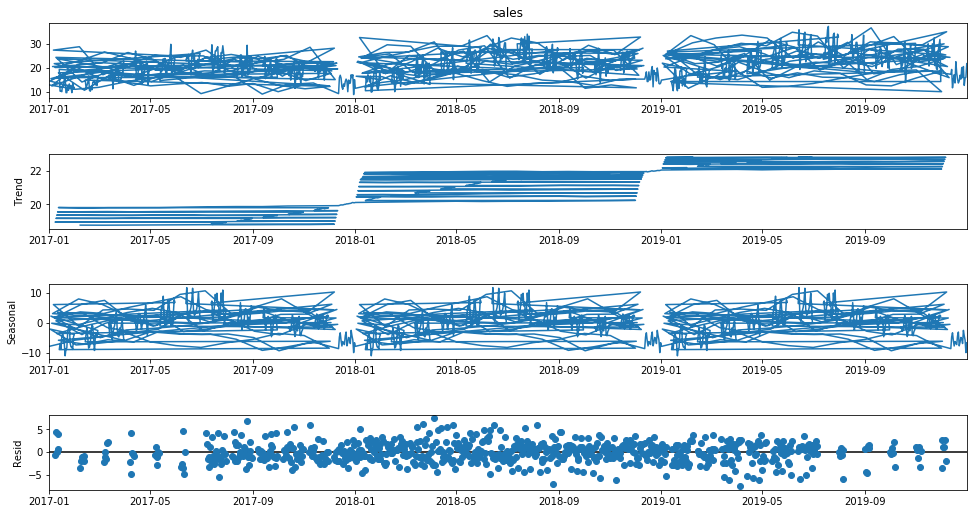

In [40]:
res = sm.tsa.seasonal_decompose(data.sales.dropna(),freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## SARIMA Model Fitting

In [41]:
y = data['sales']
sarima = sm.tsa.statespace.SARIMAX(y, order = (7,1,7),
                                seasonal_order = (1,0,1,12),
                                 enforce_stationarity = False, enforce_invertibility=False).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                sales   No. Observations:                 1095
Model:             SARIMAX(7, 1, 7)x(1, 0, [1], 12)   Log Likelihood               -2435.149
Date:                              Mon, 12 Apr 2021   AIC                           4904.298
Time:                                      00:44:17   BIC                           4988.943
Sample:                                           0   HQIC                          4936.357
                                             - 1095                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9507      0.047    -20.266      0.000      -1.043      -0.859
ar.L2         -0.9527      0.047    -20.374      0.000      -1.044      -0.861
ar.L3         -0.9509      0.047    -20.289      0.000      -1.043      -0.859
ar.L4         -0.9533      0.047    -20.335      0.000      -1.045      -0.861
ar.L5         -0.9529      0.047    -20.320      0.000      -1.045      -0.861
ar.L6         -0.9527      0.047    -20.350      0.000      -1.044      -0.861
ar.L7          0.0477      0.047      1.018      0.309      -0.044       0.140
ma.L1          0.1688      0.045      3.771      0.000       0.081       0.256
ma.L2          0.2233      0.088      2.532      0.011       0.050       0.396
ma.L3          0.1831      0.062      2.929      0.003       0.061       0.306
ma.L4          0.1998      0.071      2.828      0.005       0.061       0.338
ma.L5          0.2218      0.090      2.473      0.013       0.046       0.398
ma.L6          0.1648      0.043      3.810      0.000       0.080       0.250
ma.L7         -0.7656      0.078     -9.848      0.000      -0.918      -0.613
ar.S.L12       0.0379      0.475      0.080      0.936      -0.893       0.969
ma.S.L12      -0.0641      0.476     -0.135      0.893      -0.997       0.869
sigma2         5.8918      0.681      8.655      0.000       4.558       7.226
===================================================================================
Ljung-Box (Q):                       32.45   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.80   Prob(JB):                         0.37
Heteroskedasticity (H):               1.38   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Plot Diagnostics

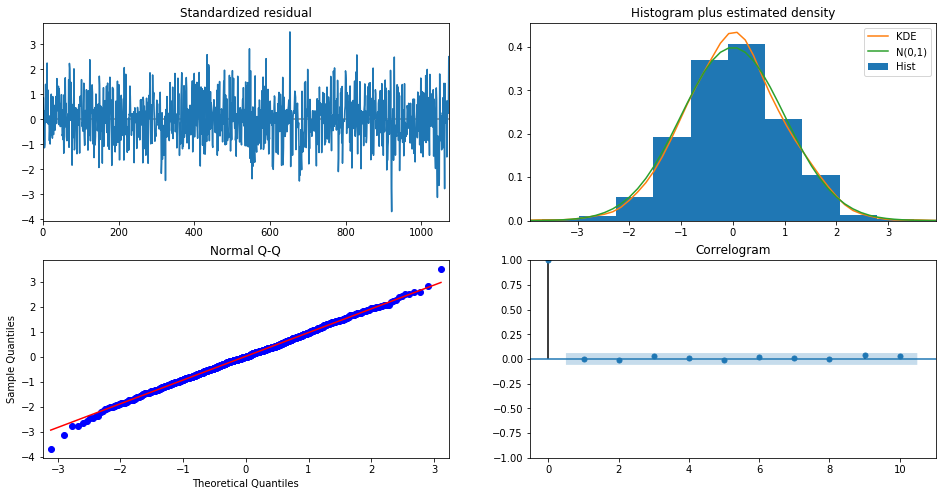

In [42]:
sarima.plot_diagnostics(figsize=(16, 8))
plt.show()

#### In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

#### The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

#### These observations lead us to conclude that this model produces a satisfactory fit that could help us understand our time series data and forecast future values.

## RMSE Calculation

In [43]:
pred = sarima.predict(start = int(div*len(data)))


rmse = sqrt(mean_squared_error(tes, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.435


## Accuracy Calculation

In [44]:
avg_sales = y.mean()
err_perc = rmse/avg_sales*100
acc = 100 - err_perc

print('SARIMAX Model Accuracy: %.3f' % acc)

SARIMAX Model Accuracy: 88.415


## Forecast Comparison of Predicted and Real Values 

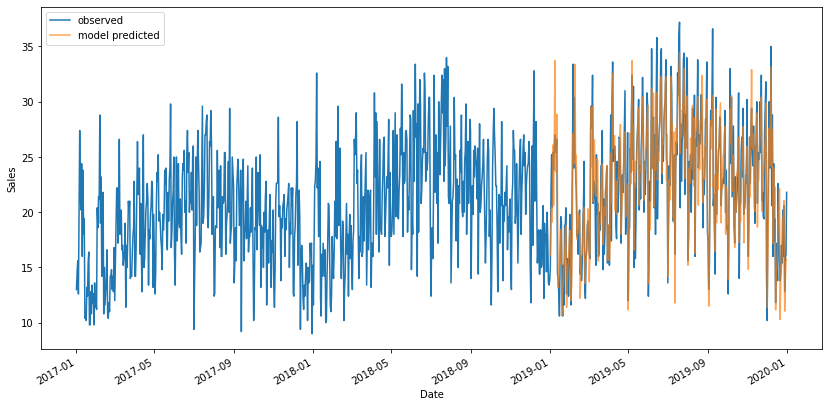

In [45]:
pred = sarima.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='model predicted', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

## Demand Forecasting for Next Month

In [46]:
stps = 31
results = round(sarima.forecast(steps = stps), 2)

future = []
last_date = temp_date["date"].iloc[-1]
last_date = datetime.strptime(last_date, '%d-%m-%y').date()
t_d = last_date

for i in range(stps):
    t_d = t_d + timedelta(days = 1)
    future.append(t_d)

fc = pd.DataFrame(future)
fc.rename(columns = {fc.columns[0]: 'Future Dates'}, inplace = True)
fc.insert(1, "Forecasted Sales", list(results))

## Forecast Results 

In [47]:
print(fc.to_string(index = False))

Future Dates  Forecasted Sales
  2020-01-01             21.13
  2020-01-02             20.91
  2020-01-03             23.11
  2020-01-04             13.22
  2020-01-05             15.82
  2020-01-06             16.83
  2020-01-07             17.22
  2020-01-08             20.79
  2020-01-09             20.93
  2020-01-10             23.09
  2020-01-11             13.24
  2020-01-12             15.62
  2020-01-13             16.82
  2020-01-14             17.07
  2020-01-15             20.73
  2020-01-16             20.93
  2020-01-17             23.08
  2020-01-18             13.24
  2020-01-19             15.73
  2020-01-20             16.83
  2020-01-21             17.06
  2020-01-22             20.74
  2020-01-23             20.94
  2020-01-24             23.08
  2020-01-25             13.24
  2020-01-26             15.70
  2020-01-27             16.83
  2020-01-28             17.04
  2020-01-29             20.76
  2020-01-30             20.95
  2020-01-31             23.08
